#Thoughts

In [ ]:
'''
  1. Data preprocessing
    1.1 将mp3格式转化为可训练的vector
      可以先看一下IO 的Tutor 是否和我想象中的一样
    1.2 如何批量loading mp3音乐,都有哪些数据预处理技巧?
      先download zip, 然后unzip
  2. Sampling(要么一次性做成batch,要么一个一个sample地来)
      必须先设计网络结构，再create samples
      batch 训练方式?
      2 channels 怎么办? 直接扔进去? 看做是一个?
      或者拆成两个线路去训练

      20秒钟在标准化的模型里....那就是16000*20一组
      范围性的输入怎么处理?

  3. Building network
      GRU就够了, lstm有点点麻烦
      实际上我要的是结合每个slice hidden content的最后output和Pytu无差别
      至于模型结构，因为数据量比较庞大，应该要稍稍复杂一些
      >RNNlayer的话，一个就够，现在应该把重点放在batch training上
      >输入数据在某范围长度内,如果长度不够就用0 补齐?
      >Tensor input 是20s，但是允许输入是15-20,若超过则在外部处理
      >输入不够的末端全部用0替代---先全部截取20s,然后在末端增添随机数量的0?
      包装好的RNN是否每次只读取一个token?


  4. Training
      Using GPU to train
  5. Plotting
  6. evaluation
  7. trial
    个人trial的时候也要normalize输入
'''

#1.Loading the data

##1.1 Mounting Google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Project_learning/Music_classifier"
# %cd "/content/drive/MyDrive/Music_classifier"
%ls

Mounted at /content/drive
/content/drive/MyDrive/Project_learning/Music_classifier
'12 28 结论分享.gdoc'   Audios_sr.npy       Music_recognition.ipynb  'Version 1'
 AI.7z                  database/          'Project Schedule.gdoc'    version1.pth
 Audios_2kc.npy         database.zip        runs/                     version2_2kc.pth
 Audios.npy             model_weights.pth  'Updated Versions'/        version2.pth


##1.2 Transforming all MP3 to Tensor

In [3]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import glob

#1. Define required list

audios=[]
file_names=[]

# sample rate 被normalize成16000了,原本的有44100到48000不等

#2. Get all the file names: ex. 'database/03007.mp3'

file_names=glob.glob('database/*.mp3')
file_names=sorted(file_names) #确保每次读写的map3顺序都一致
print(len(file_names))
print(file_names)

78
['database/03001.mp3', 'database/03002.mp3', 'database/03003.mp3', 'database/03004.mp3', 'database/03005.mp3', 'database/03006.mp3', 'database/03007.mp3', 'database/03008.mp3', 'database/03009.mp3', 'database/03010.mp3', 'database/03011.mp3', 'database/04001.mp3', 'database/04002.mp3', 'database/04003.mp3', 'database/04004.mp3', 'database/04005.mp3', 'database/04006.mp3', 'database/04007.mp3', 'database/04008.mp3', 'database/04009.mp3', 'database/04010.mp3', 'database/04011.mp3', 'database/05001.mp3', 'database/05002.mp3', 'database/05003.mp3', 'database/05004.mp3', 'database/05005.mp3', 'database/05006.mp3', 'database/05007.mp3', 'database/05008.mp3', 'database/05009.mp3', 'database/05010.mp3', 'database/05011.mp3', 'database/05012.mp3', 'database/05013.mp3', 'database/05014.mp3', 'database/05015.mp3', 'database/05016.mp3', 'database/05017.mp3', 'database/05018.mp3', 'database/05019.mp3', 'database/05020.mp3', 'database/05021.mp3', 'database/05022.mp3', 'database/05023.mp3', 'datab

In [4]:




#3. create_spectrogram,which return a normalized graph
def create_spectrogram(audio):
    # Convert audio to spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=22050, n_mels=128)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram_db

#4. Adding all the graphs into the list
for i in range(len(file_names)):
  audio,sr = librosa.load(file_names[i],sr=None,mono=False)
  spectrogram_first = create_spectrogram(audio[0])  # First channel
  spectrogram_second = create_spectrogram(audio[1])  # Second channel
  combined_spectrogram = np.stack((spectrogram_first, spectrogram_second), axis=0)  # Shape (2, height, width)
  audios.append(combined_spectrogram)
  if (i+1)%5==0 or i+1==78:
    print("Loaded %d/78 "%(i+1))




Loaded 5/78 
Loaded 10/78 
Loaded 15/78 
Loaded 20/78 
Loaded 25/78 
Loaded 30/78 
Loaded 35/78 
Loaded 40/78 
Loaded 45/78 
Loaded 50/78 
Loaded 55/78 
Loaded 60/78 
Loaded 65/78 
Loaded 70/78 
Loaded 75/78 
Loaded 78/78 


In [ ]:
audio,sr = librosa.load(file_names[0],sr=None,mono=False)
print(audio.shape)
mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=50)
print(mfccs.shape)
# import torchaudio
# audio,sample_rate = torchaudio.load(file_names[0])

# print(audios[0].size())

spectrogram = librosa.feature.melspectrogram(y=audio, sr=22050, n_mels=128)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
print(spectrogram_db.shape)

(2, 9967188)
(2, 50, 19468)
(2, 128, 19468)


In [5]:
# Transforming the music graphs to Tensors
import torch
for i in range(len(audios)):
  audios[i]=torch.tensor(audios[i],dtype=torch.float32)
  print(i,audios[i].shape)


# 注意因为每个audio原本长度不一样，所以第三个维度的时间轴长自然也是不一样
# 因此无法统一划分为Tensor(报错),但可以把每个music graph 单独定义为一个Tensor,之后采样后用stack合并

0 torch.Size([2, 128, 19468])
1 torch.Size([2, 128, 16423])
2 torch.Size([2, 128, 15970])
3 torch.Size([2, 128, 18780])
4 torch.Size([2, 128, 15889])
5 torch.Size([2, 128, 20723])
6 torch.Size([2, 128, 18141])
7 torch.Size([2, 128, 13506])
8 torch.Size([2, 128, 11587])
9 torch.Size([2, 128, 16281])
10 torch.Size([2, 128, 14303])
11 torch.Size([2, 128, 21343])
12 torch.Size([2, 128, 35326])
13 torch.Size([2, 128, 20931])
14 torch.Size([2, 128, 26224])
15 torch.Size([2, 128, 24237])
16 torch.Size([2, 128, 28983])
17 torch.Size([2, 128, 25573])
18 torch.Size([2, 128, 20091])
19 torch.Size([2, 128, 33281])
20 torch.Size([2, 128, 32112])
21 torch.Size([2, 128, 36797])
22 torch.Size([2, 128, 21718])
23 torch.Size([2, 128, 35481])
24 torch.Size([2, 128, 6863])
25 torch.Size([2, 128, 10965])
26 torch.Size([2, 128, 4368])
27 torch.Size([2, 128, 5398])
28 torch.Size([2, 128, 17359])
29 torch.Size([2, 128, 21808])
30 torch.Size([2, 128, 72111])
31 torch.Size([2, 128, 17458])
32 torch.Size([2, 128

##1.3 Prepare GPU

#2.Preparing training data

In [ ]:
# from re import I
# low=[]
# for i in range(len(audios)):
#   if audios[i].size(2)<1600:
#     low.append((audios[i].size(2),i))
# for l in low:
#   print(l,file_names[l[1]])

# '''
# 问题音频
# (1281, 56) database/06112.mp3
# (1448, 60) database/06116.mp3
# (557, 65) database/06121.mp3
# (1576, 66) database/06201.mp3
# (781, 69) database/06204.mp3
# (914, 79) database/06214.mp3
# (557, 84) database/06219.mp3
# database/06206.mp3
# database/06216.mp3
# database/06212.mp3
# '''

In [6]:
import random
#1. Define all the targets
data_size=8000
frame_size=1600

sample_data=[]
sample_labels=[]

#2.Get a random subgraph from a given graph:(20s)
  #大概是 0.0116秒raw音频一帧
  #1720帧每20秒,取1750
  #1289帧每15秒 取1200
  #model是否能接受不同input_size呢?
  #model可以但是做不到batch training了，因此我们取一个 1600帧---允许输入略短一些
  #会filter到1600帧

def getSample(required_label):
  # print(graph.size())
  # label=random.choice([0,55])# 限定范围内的曲目(randomint 包含上下界)
  graph=audios[required_label]
  start_i=random.randint(0,graph.size(2)-1600)
  sample=torch.zeros([2,128,1600],dtype=torch.float32)
  sample.copy_(graph[:,:,start_i:(start_i+1600)])
  sample=sample[:,:,::50]
  #print(sample.size())
  return sample,required_label

def getBatchSample(batch_size):
  batch_data=[]
  batch_labels=[]
  for i in range(batch_size):
    # label=(i%2)*55 #0 or 55
    label=random.randint(0,77)
    data,label=getSample(label)
    batch_data.append(data)
    batch_labels.append(label)
  batch_data=torch.stack(batch_data)
  batch_labels=torch.tensor(batch_labels)
  return batch_data,batch_labels

# a,b=getBatchSample(10)
# print(a)
# print(b)
# 还有本来就低于20秒的音乐?
#3.Get all data_samples and labels
# for i in range(data_size):
#   label=i%78
#   sub_graph=getSample(audios[i%78])
#   sample_labels.append(label)
#   sample_data.append(sub_graph)
#   if (i+1)%5000==0:
#     print('i= %d | 8000'%(i+1))
# 您的会话因占满了所有可用 RAM 而导致崩溃
# 改进:把100000改成30000,每次load只练30000的随机样本，
# 10000都不行,要不就直接train,跳过datasets 阶段，这样只会增加时间成本，但不至于RAM溢出

In [ ]:
# #4.Storing the result for future use
# sample_data=torch.tensor(sample_data,dtype=torch.float32)
# sample_labels=torch.tensor(sample_labels,dtype=torch.float32)
# torch.save(sample_data,'sample_data.pt')
# torch.save(sample_labels,'sample_labels.pt')
# sample_data.load('sample_data.pt')
# sample_labels.load('sample_labels.pt')

In [ ]:
#5.shuffle the data & divide into training and validation sets
# idx=torch.randperm(sample_labels.size(0))
# train_X=[]
# train_y=[]
# test_X=[]
# test_y=[]
# for i in range(idx.size(0)):
#   if(i<1000):
#     test_X.append(sample_data[i])
#     test_y.append(sample_data[i])
#   else:
#     train_X.append(sample_data[i])
#     train_y.append(sample_data[i])

# train_X=torch.stack(train_X,dtype=torch.float32)
# train_y=torch.stack(train_y,dtype=torch.float32)
# test_X=torch.stack(test_X,dtype=torch.float32)
# test_y=torch.stack(test_y,dtype=torch.float32)
# stack 会导致维数多1,就是把整个list 看做单独元素合并的

#3.Building the model

In [ ]:
"""
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        # kernal size决定 output size 最高维度
        # conv层无所谓input size,因为每次input只遍历一个image
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=(3, 3), stride=1, padding=1)  # 2 input channels for stereo
        self.pool1 = nn.AvgPool2d(kernel_size=(2, 4))
        self.pool2 = nn.AvgPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.conv6 = nn.Conv2d(32, 8, kernel_size=(3, 3), stride=1, padding=1)
        # Adaptive pooling to ensure output size is fixed
        # self.adaptive_pool = nn.AdaptiveAvgPool2d((4,50)) #决定最后两个维度

        self.fc1 = nn.Linear(384,192)
        self.fc2 = nn.Linear(192,128)
        self.fc3 = nn.Linear(128, num_classes)
        self.softmax=nn.LogSoftmax(dim=1)

    def forward(self, x):
        # input_shape: N,2,128,1600
        x = self.pool1(F.relu(self.conv1(x))) # conv_out 32 128 1600 --- pool: 32 64 400
        x = self.pool1(F.relu(self.conv2(x))) # conv_out 64 64 800 --- pool: 64 32 100
        x = self.pool2(F.relu(self.conv3(x))) # conv_out 128 32 100 --- pool: 128 16 50
        x = self.pool2(F.relu(self.conv4(x))) # conv_out 64 16 50 --- pool:64 8 25
        x = self.pool2(F.relu(self.conv5(x))) # conv_out 32 8 25 --- pool:32 4 12
        x = F.relu(self.conv6(x)) # conv_out 8 4 12
        # x = self.adaptive_pool(x)
        # Flatten the tensor
        x = x.view(x.size(0),-1) # flatten: batch_size,384
        x = F.relu(self.fc1(x)) # fc1: 192
        x = F.relu(self.fc2(x)) # fc2L 128
        x = F.relu(self.fc3(x)) # batch_size,num_classes
        x = self.softmax(x)
        return x
"""
# view 的最后两个维度成功了,48,问题在于第一个维度为何是1024?
# ERROR 原来，我的问题在于 没考虑batch size维度，x.size(0)保留的是batch size
# ERROR 大概是 不能half flatten, 全神经网络只能接受 (batch_size,b) 的size

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        # kernal size决定 output size 最高维度
        # conv层无所谓input size,因为每次input只遍历一个image
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=(3, 3), stride=1, padding=1)  # 2 input channels for stereo
        self.pool1 = nn.AvgPool2d(kernel_size=(4, 2))
        self.pool2 = nn.AvgPool2d(kernel_size=(2, 4))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 8, kernel_size=(3, 3), stride=1, padding=1)
        # Adaptive pooling to ensure output size is fixed
        # self.adaptive_pool = nn.AdaptiveAvgPool2d((4,50)) #决定最后两个维度

        self.fc1 = nn.Linear(512,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, num_classes)
        self.softmax=nn.LogSoftmax(dim=1)

    def forward(self, x):
        # input_shape: N,2,128,1600
        x = F.relu(self.conv1(x)) # conv_out 32 128 32
        x = self.pool1(F.relu(self.conv2(x))) # conv_out 64 128 32 --- pool: 64 32 16
        x = F.relu(self.conv3(x)) # conv_out 128 32 16
        x = self.pool1(F.relu(self.conv4(x))) # conv_out 64 32 16 --- pool:64 8 8
        #x = self.pool2(F.relu(self.conv5(x)))
        x = F.relu(self.conv6(x)) # conv_out 8 8 8
        # x = self.adaptive_pool(x)
        # Flatten the tensor
        x = x.view(x.size(0),-1) # flatten: batch_size,512
        x = F.relu(self.fc1(x)) # fc1: 256
        x = F.relu(self.fc2(x)) # fc2L 128
        x = F.relu(self.fc3(x)) # batch_size,num_classes
        x = self.softmax(x)
        return x

In [ ]:
import torch
x=torch.ones(5,6,7,8)
x=x.view(5,6,-1)
print(x.size())

torch.Size([5, 6, 56])


#4.Training the model

In [8]:
# Hyperparameters
num_classes = 78
num_epochs = 5000
learning_rate = 0.0001
batch_size = 20

# Preparing model
model = CNNModel(num_classes)
# model.load_state_dict(torch.load('version1.pth',weights_only=True))

In [9]:
# Prepare your data
X_train, y_train = getBatchSample(batch_size)  # Replace with your audio files list

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [16]:
# Initialize the model, loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# print(model)
# Training loop
c=0
for epoch in range(num_epochs):
    accuracy=[]
    X_train, y_train = getBatchSample(batch_size)
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    for inputs, labels in train_loader:
        c+=1
        optimizer.zero_grad()  # Clear gradients
        #print(inputs.size())
        outputs = model(inputs)  # Forward pass
        #print(outputs)
        _,pred=outputs.max(dim=1)
        # output size=batchsize, training is done in batches
        # if(c%20==0 or c==1):
          # print(torch.stack((pred,labels),dim=1))
        accuracy.append((torch.sum((pred==labels),0).item())/batch_size)
        loss = criterion(outputs, labels)  # Compute loss
        # 不需要把outputs设计成一个值
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
    # print(accuracy)
    avg_accuracy=sum(accuracy)/len(accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {avg_accuracy*100:.4f}%')
torch.save(model.state_dict(),'version1.pth')

# '''
#   问题在于,fc1之前为什么是32x55808? 到底经历了些什么?
#   872,512 是fc1的输入输出
#   经历了flatten
# '''

# 最新: 观察到 pred 过于一致，怀疑是模型出了问题，为什么相同batch的output class 全部一样
# 扩大batchsize 为30，问题也一模一样
# 逻辑上没找到问题，增加sample 的label多样性试试-----没用, 是模型结构太大了吗?
# 从0开始搭建呢? 发现pred有变化了，说明可能是模型出现了奇怪的过拟合
# 模型规模太大了，导致很轻易地就被困在了局部最优解内？看看能不能通过正则化解决这个问题

Epoch [1/5000], Loss: 2.2867, Accuracy: 45.0000%
Epoch [2/5000], Loss: 2.9812, Accuracy: 35.0000%
Epoch [3/5000], Loss: 2.6363, Accuracy: 45.0000%
Epoch [4/5000], Loss: 3.5931, Accuracy: 20.0000%
Epoch [5/5000], Loss: 2.8252, Accuracy: 45.0000%
Epoch [6/5000], Loss: 2.2784, Accuracy: 50.0000%
Epoch [7/5000], Loss: 2.5489, Accuracy: 50.0000%
Epoch [8/5000], Loss: 3.0217, Accuracy: 40.0000%
Epoch [9/5000], Loss: 2.9664, Accuracy: 35.0000%
Epoch [10/5000], Loss: 3.5573, Accuracy: 20.0000%
Epoch [11/5000], Loss: 3.4662, Accuracy: 25.0000%
Epoch [12/5000], Loss: 2.9091, Accuracy: 35.0000%
Epoch [13/5000], Loss: 3.0831, Accuracy: 35.0000%
Epoch [14/5000], Loss: 3.1329, Accuracy: 35.0000%
Epoch [15/5000], Loss: 2.6024, Accuracy: 45.0000%
Epoch [16/5000], Loss: 3.6999, Accuracy: 25.0000%
Epoch [17/5000], Loss: 2.8184, Accuracy: 40.0000%
Epoch [18/5000], Loss: 3.3277, Accuracy: 30.0000%
Epoch [19/5000], Loss: 2.1882, Accuracy: 55.0000%
Epoch [20/5000], Loss: 2.1114, Accuracy: 55.0000%
Epoch [21

In [ ]:
torch.save(model.state_dict(),'version1.pth')

In [ ]:
import torch
a=torch.ones(32,5)
a,_=a.max(dim=1,keepdim=True)
print(a)
print(_)
l=torch.ones(32,1)
l[0,0]=0
l[11,0]=0
print(torch.sum(a==l,0).item())

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
30


#5.Evaluating the model

In [23]:
X_test, y_test = getBatchSample(batch_size*100)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
accuracy=[]
for inputs, labels in test_loader:
    # print(inputs.size())
    outputs = model(inputs)  # Forward pass
    _,pred=outputs.max(dim=1)
    # output size=batchsize, training is done in batches
    accuracy.append((torch.sum((pred==labels),0).item())/batch_size)
    # print(accuracy)
avg_accuracy=sum(accuracy)/len(accuracy)
print(f'Accuracy: {avg_accuracy*100:.4f}%')

# 为什么output 不是10组呢? 漏了一处train 改成 test

Accuracy: 41.4500%


# Reference

In [ ]:
%ls
# !unzip database.zip

database/  database.zip  Music_recognition.ipynb


In [ ]:
# 尝试外部下载结果实在是搞不来
# !pip install torchaudio
# !pip install gdown
# !pip install --upgrade --no-cache-dir gdown
# !gdown https://drive.google.com/uc?export=download&id=1sxkvXWEeUiwC7kc1skQZ7x6nTcT5Yez-&confirm=t
# https://drive.google.com/uc?export=download&id=1sxkvXWEeUiwC7kc1skQZ7x6nTcT5Yez-
# https://drive.google.com/file/d/1sxkvXWEeUiwC7kc1skQZ7x6nTcT5Yez-/view?usp=sharing

44100


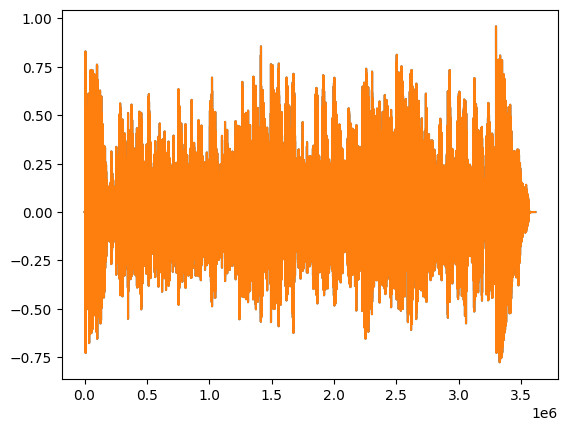

In [ ]:
print(sample_rate)
plt.figure()
plt.plot(waveform.t().numpy())
plt.show()

In [ ]:
#用集成的RNN模型，而非in scratch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Sample data
data = torch.randn(100, 10, 20)  # 100 sequences, each of length 10, with 20 features
labels = torch.randint(0, 2, (100, 10))  # Binary labels for each sequence

# Create DataLoader
dataset = TensorDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

input_size = 20
hidden_size = 50
output_size = 1

model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    for batch_data, batch_labels in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels.float())
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


In [ ]:

# Path to your MP3 file
mp3_path = "/content/drive/MyDrive/Project_learning/Music_classifier/database/M03001.mp3"

# Load the MP3 file
waveform, sample_rate = torchaudio.load(mp3_path)

# Print waveform and sample rate
print(f"Waveform shape: {waveform.shape}")
print(f"Sample rate: {sample_rate}")

# Optional: Normalize the waveform
waveform = waveform / waveform.abs().max()

# Optional: Resample the waveform to a different sample rate
resample_rate = 16000
resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=resample_rate)
waveform = resampler(waveform)

print(f"Resampled waveform shape: {waveform.shape}")
print(f"Resampled sample rate: {resample_rate}")

# resample意味着减小resolution

In [ ]:
'''
  Waveform shape: torch.Size([2, 9967188])--- 2代表两个发声channel,9967188代表第几个时间采样点(存储频率),
  Sample rate: 44100
  Resampled waveform shape: torch.Size([2, 3616214])
  Resampled sample rate: 16000
'''

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义RNN模型
class AudioRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AudioRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 超参数设置
input_size = 40  # 例如，MFCC特征的维度
hidden_size = 128
num_layers = 2
num_classes = 10  # 例如，分类任务的类别数
learning_rate = 0.001
num_epochs = 20

# 创建模型、损失函数和优化器
model = AudioRNN(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 假设train_loader是加载音频数据的DataLoader
for epoch in range(num_epochs):
    for i, (audios, labels) in enumerate(train_loader):
        audios = audios.to(device)
        labels = labels.to(device)

        # 前向传播
        outputs = model(audios)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


In [ ]:
#原本的torchaudio版本
for i in range(len(file_names)):
  audio,sample_rate = librosa.load(file_names[i],sr=None,mono=False)
  # normalize the data
  waveform = waveform / waveform.abs().max()
  resample_rate = 16000
  resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=resample_rate)
  waveform = resampler(waveform)
  # appending all the data
  waveforms.append(waveform)
  if (i+1)%5==0:
    print("Loaded %d/85 "%(i+1))
